In [351]:
import numpy as np
import pandas as pd
import scipy
import sys
import os
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

In [352]:
cmap=plt.cm.tab20
cmaplist = [cmap(i) for i in range(cmap.N)]

In [353]:
mods = ["Linear", "MLP_baselines", "MTL"]
phens = ["CERAD", "BRAAK", "PLAQUES", "TANGLES", "ABETA_IHC", "TAU_IHC"]
path_to_preds = "../../Pipeline_Outputs_Submitted/External_Validation/Cleaned/Model_Predictions/"

### Human

In [354]:
t_stat = {}
t_ps= {}
dfs = {}
for mod in mods:
    df = pd.read_csv(path_to_preds + "%s/all_human.csv"%mod)
    dfs[mod] = df
    t_stat[mod] = {}
    t_ps[mod] = {}

    for yvar in ['CERAD', 'BRAAK', 'PLAQUES', 'TANGLES',
           'ABETA_IHC', 'TAU_IHC', 'AB_RELATED', 'TAU_RELATED', 'AVG']:

        t_stat[mod][yvar] = {}
        t_ps[mod][yvar] = {}

        t,p = scipy.stats.ttest_ind(df[df["AD"]==1][yvar].values,  df[df["AD"]==0][yvar].values)
        t_stat[mod][yvar]["all"] = t
        t_ps[mod][yvar]["all"] = p
      
    
        for study in np.unique(df["study"]):
            subdf = df[df["study"]==study]
            t,p = scipy.stats.ttest_ind(subdf[subdf["AD"]==1][yvar].values, subdf[subdf["AD"]==0][yvar].values)
            t_stat[mod][yvar][study] = t
            t_ps[mod][yvar][study] = p

amp-ad_msbb [12.085109254151837, 15.010835850618214, 17.255303811113986]
MayoRNASeq.tsv [8.696563470729208, 11.605545025842991, 9.086570189836078]
HBTRC_GEO [9.993804485341146, 14.175126206699728, 14.513736500495046]
all [16.853022389993296, 21.48236550571764, 22.976364470733326]


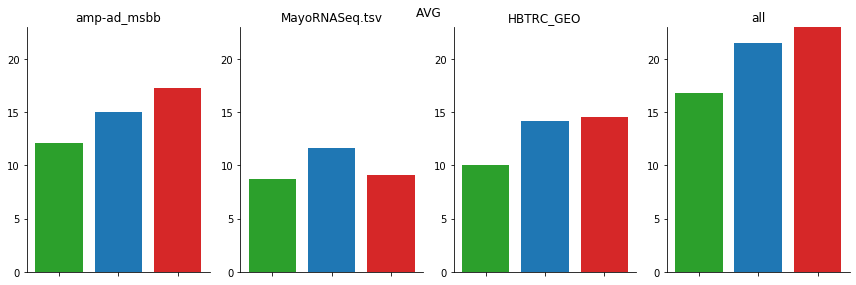

In [355]:
dsets_list = ['amp-ad_msbb', 'MayoRNASeq.tsv', "HBTRC_GEO", "all"]
# for yvar in ['CERAD', 'BRAAK', 'PLAQUES', 'TANGLES',
#        'ABETA_IHC', 'TAU_IHC', 'AB_RELATED', 'TAU_RELATED', 'AVG']:
for yvar in ['AVG']:
    f,axs = plt.subplots(1,4, figsize=(12,4))
    
    lim = np.max([[t_stat[mod][yvar][dset] for mod in ["Linear", "MLP_baselines", "MTL"]] for dset in dsets_list])
    
    for i, dset in enumerate(dsets_list):

        lin,mlp,mtl= axs[i].bar(mods, [t_stat[mod][yvar][dset] for mod in ["Linear", "MLP_baselines", "MTL"]], 
                                align='center', alpha=1, ecolor='black')
        
        print(dset, [t_stat[mod][yvar][dset] for mod in ["Linear", "MLP_baselines", "MTL"]])
               
        lin.set_facecolor(cmaplist[4])
        mlp.set_facecolor(cmaplist[0])
        mtl.set_facecolor(cmaplist[6])

        axs[i].set_xticks(mods)
        axs[i].set_xticklabels("")

        axs[i].set_title(dset)
        
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        axs[i].set_ylim(0,lim)
    plt.suptitle(yvar)
        
    plt.tight_layout()


In [356]:
for mod in mods:
    dfs[mod]["model"] = mod


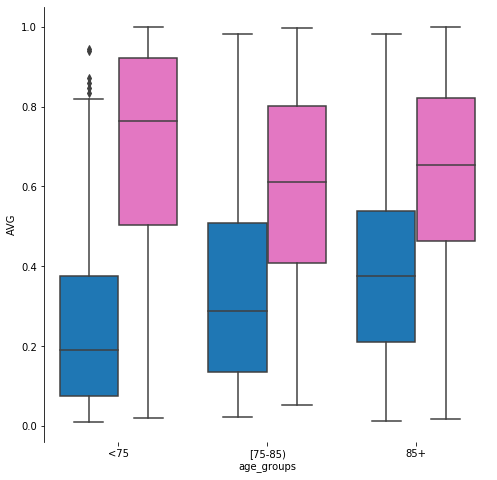

In [357]:
f, ax = plt.subplots(1,1,figsize=(8,8))

xorder = np.array(["<75","[75-85)", "85+"])
yvar = 'AVG'

g=sns.catplot(x="age_groups", y=yvar, hue="AD",col="model",aspect=1.2, order=xorder,ax=ax,
            kind="box",ci="sd", data= dfs["MTL"], hue_order=[0,1], palette=[cmaplist[0], cmaplist[12]], legend=False, saturation=1);

plt.title(mod)

ax.set_facecolor('None')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.get_legend().remove()
plt.close(2)
plt.show()

In [358]:
groups = []
vals = []
for sname, s_df in dfs["MTL"].groupby("AD"):
    stxt = "AD" if sname==1 else "Control"
    for aname, a_df in s_df.groupby("age_groups"):
        groups.append(str(sname)+"-"+aname)
        vals.append(a_df["AVG"].values)

In [359]:
group_ordering = ['0-<75', '1-<75', '0-[75-85)', '1-[75-85)', '0-85+','1-85+']

In [360]:
for _, g_name in enumerate(group_ordering):
    i = groups.index(g_name)

    print(g_name+" (%i),"%len(vals[i]), end="")
    for _, g2_name in enumerate(group_ordering):
        j = groups.index(g2_name)
        t_res = scipy.stats.ttest_ind(vals[i], vals[j])
        stars = ""
        if t_res[1] < .05:
            stars += "*"
        if t_res[1] < .01:
            stars += "*"
        if t_res[1] < .001:
            stars += "*"
            
        print(stars+",",end="")
    print()

0-<75 (179),,***,**,***,***,***,
1-<75 (95),***,,***,*,***,,
0-[75-85) (134),**,***,,***,,***,
1-[75-85) (243),***,*,***,,***,*,
0-85+ (337),***,***,,***,,***,
1-85+ (554),***,,***,*,***,,


In [361]:
sourcedata_cols = ["AD","age_groups"]

sourcedata = dfs["MTL"][sourcedata_cols]

for mod in mods:
    if mod=="MTL":
        sourcedata["MD-AD_predicted_neuropath_score"] = dfs[mod]["AVG"]
    else:
        sourcedata[mod+"_predicted_neuropath_score"] = dfs[mod]["AVG"]
    
sourcedata.to_csv("sourcedata/2c_ext_val_human_brain.csv", index=False)
    

/homes/gws/nbbwang/anaconda3/envs/py36-test2/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/homes/gws/nbbwang/anaconda3/envs/py36-test2/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


### distribution plots

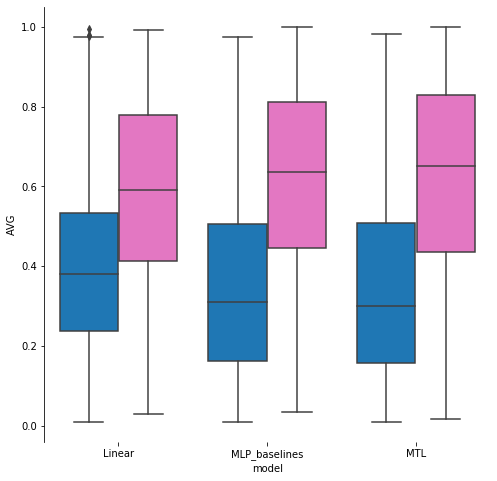

In [363]:
alldfs = pd.concat(dfs.values())


f, ax = plt.subplots(1,1,figsize=(8,8))

g=sns.catplot(x="model", y=yvar, hue="AD",aspect=1,ax=ax,
            kind="box",ci="sd", data= alldfs, hue_order=[0,1], palette=[cmaplist[0], cmaplist[12]],
              legend=False, saturation=1);


ax.set_facecolor('None')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.get_legend().remove()
plt.close(2)



# mouse

In [364]:
t_stat = {}
t_ps= {}
dfs = {}
for mod in mods:
    df = pd.read_csv(path_to_preds + "%s/Mouse.csv"%mod)
    
    df["AD"] = df["strain"].apply(lambda x: x if x=="WILD" else "AD")
    df["time"] = df["age"].apply(lambda x: int(x[:-6] ))
    df["AD-region"] = df["AD"].values+"_"+df["region"].values
    df["strain-region"] = df["strain"].values+"_"+df["region"].values


    dfs[mod] = df
    t_stat[mod] = {}
    t_ps[mod] = {}

    for yvar in ['CERAD', 'BRAAK', 'PLAQUES', 'TANGLES',
           'ABETA_IHC', 'TAU_IHC', 'AB_RELATED', 'TAU_RELATED', 'AVG']:

        t_stat[mod][yvar] = {}
        t_ps[mod][yvar] = {}

        t,p = scipy.stats.ttest_ind(df[df["AD"]==1][yvar].values,  df[df["AD"]==0][yvar].values)
        t_stat[mod][yvar]["all"] = t
        t_ps[mod][yvar]["all"] = p

In [365]:
for mod in mods:
    t_stat[mod] = {}
    t_ps[mod]= {}
    
    df = dfs[mod]

    for yvar in ['CERAD', 'BRAAK', 'PLAQUES', 'TANGLES',
           'ABETA_IHC', 'TAU_IHC', 'AB_RELATED', 'TAU_RELATED', 'AVG']:

        t_stat[mod][yvar] = {}
        t_ps[mod][yvar] = {}

        t,p = scipy.stats.ttest_ind(df[df["AD"]=="AD"][yvar].values, df[df["AD"]=="WILD"][yvar].values)
        t_stat[mod][yvar]["all"] = t
        t_ps[mod][yvar]["all"] = p


        for strain in np.setdiff1d(np.unique(df["strain"]), "WILD"):
            subdf = df[((df["strain"] == strain) | (df["strain"] == "WILD"))]
            
            t,p = scipy.stats.ttest_ind(subdf[subdf["AD"]=="AD"][yvar].values, subdf[subdf["AD"]=="WILD"][yvar].values)
            t_stat[mod][yvar][strain] = t
            t_ps[mod][yvar][strain] = p


            
             

In [366]:
# TEMP: compare het and ho for bar chart alts
for mod in mods:
    df = dfs[mod]
    for yvar in ['AVG']:
        
        t,p = scipy.stats.ttest_ind(df[df["strain"]=="HO_TASTPM"][yvar].values, df[df["strain"]=="HET_TASTPM"][yvar].values)

        print("%s: t=%.3f, p=%.4f"%(mod, t, p))



Linear: t=-0.185, p=0.8539
MLP_baselines: t=1.641, p=0.1061
MTL: t=1.620, p=0.1104


all [-1.1234966242953592, 0.8828844789377394, 1.4876032181562002]
HET_TASTPM [-2.4615917362932698, 0.8795127472949958, 1.3940458300666003]
HO_TASTPM [-2.5873495421658173, 3.0081255295358615, 3.475728461147189]
TAS10 [-1.6609196221898537, 0.7807404339047133, 1.1423011097255444]
TAU [1.3516708297839994, -1.1750994737519747, -0.7087379089856878]
TPM [1.2597330962709217, -0.43858369880213016, -0.25150026791702684]


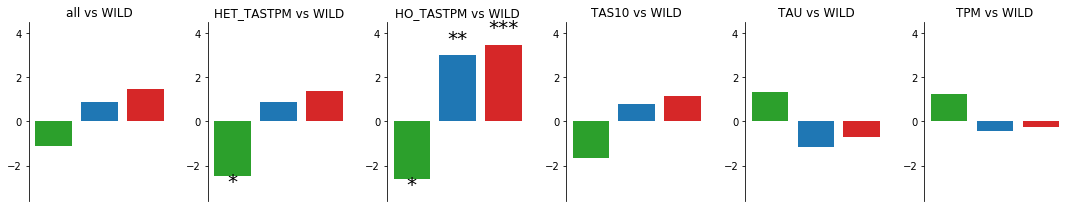

In [367]:
for yvar in ['AVG']:
    
    f,axs = plt.subplots(1,len(list(np.unique(df["strain"]))), figsize=(15,3))
    
    low_lim = np.min([[t_stat[mod][yvar][dset] for mod in ["Linear", "MLP_baselines", "MTL"]] for dset in t_ps["Linear"]["CERAD"].keys()])
    high_lim = np.max([[t_stat[mod][yvar][dset] for mod in ["Linear", "MLP_baselines", "MTL"]] for dset in t_ps["Linear"]["CERAD"].keys()])

    
    for i, dset in enumerate(t_ps["Linear"]["CERAD"].keys()):
        Ys = [t_stat[mod][yvar][dset] for mod in ["Linear", "MLP_baselines", "MTL"]]
                  
        lin,mlp,mtl= axs[i].bar(mods, Ys, align='center', alpha=1, ecolor='black')
        
        print(dset, [t_stat[mod][yvar][dset] for mod in ["Linear", "MLP_baselines", "MTL"]])


        axs[i].set_ylim(0,high_lim+1)

        lin.set_facecolor(cmaplist[4])
        mlp.set_facecolor(cmaplist[0])
        mtl.set_facecolor(cmaplist[6])
        
        axs[i].set_xticks([])

        annots = [ "***" if x > -np.log10(.001) else ("**" if x > -np.log10(.01) else \
                ("*" if x > -np.log10(.05) else "")) for x in \
                [-np.log10(t_ps[mod][yvar][dset]) for mod in ["Linear", "MLP_baselines", "MTL"]]]
        for j, txt in enumerate(annots):
            ann_x = j
            ann_y = (Ys[j]+.5) if Ys[j]>0 else  (Ys[j]-.5) 
            axs[i].text(ann_x,ann_y, txt, color='black', horizontalalignment ="center", fontsize=20)
        axs[i].set_ylim(low_lim-1,high_lim+1)

        
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)

        axs[i].locator_params(nbins=5, axis='y')
        axs[i].set_title("%s vs WILD"%dset)

        
    plt.tight_layout()

In [368]:
for mod in mods:
    dfs[mod]["model"] = mod

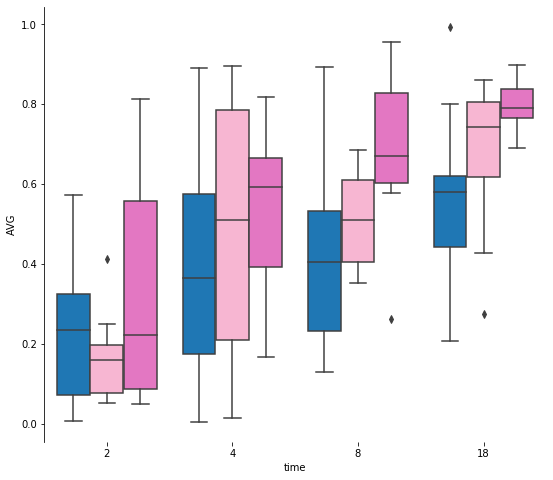

In [369]:
f, ax = plt.subplots(1,1,figsize=(9,8))

g=sns.catplot(x="time", y="AVG", hue="strain",aspect=1.5,kind="box", data=dfs["MTL"], 
              hue_order=["WILD","HET_TASTPM", "HO_TASTPM"], ax=ax,
              palette=[cmaplist[0], cmaplist[13],  cmaplist[12]],saturation=1);

ax.set_facecolor('None')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.get_legend().remove()
plt.close(2)


In [370]:
groups = []
vals = []
for sname, s_df in dfs["MTL"].groupby("strain"):
    if sname not in ["WILD", "HET_TASTPM", "HO_TASTPM"]:
        continue
    for aname, a_df in s_df.groupby("time"):
        aname=str(aname)
        groups.append(sname+"-"+aname)
        vals.append(a_df["AVG"].values)

In [371]:
group_ordering = ['WILD-2',
 'HET_TASTPM-2',
 'HO_TASTPM-2',
 'WILD-4',
 'HET_TASTPM-4',
 'HO_TASTPM-4',
 'WILD-8',
 'HET_TASTPM-8',
 'HO_TASTPM-8',
 'WILD-18',
 'HET_TASTPM-18',
 'HO_TASTPM-18']

In [372]:
for _, g_name in enumerate(group_ordering):
    i = groups.index(g_name)

    print(g_name+" (%i),"%len(vals[i]), end="")
    for _, g2_name in enumerate(group_ordering):
        j = groups.index(g2_name)
        t_res = scipy.stats.ttest_ind(vals[i], vals[j])
        stars = ""
        if t_res[1] < .05:
            stars += "*"
        if t_res[1] < .01:
            stars += "*"
        if t_res[1] < .001:
            stars += "*"
            
        print(stars+",",end="")
    print()

WILD-2 (22),,,,*,**,***,**,***,***,***,***,***,
HET_TASTPM-2 (8),,,,*,*,***,**,***,***,***,***,***,
HO_TASTPM-2 (8),,,,,,,,,*,,*,**,
WILD-4 (20),*,*,,,,,,,**,,**,***,
HET_TASTPM-4 (8),**,*,,,,,,,,,,,
HO_TASTPM-4 (8),***,***,,,,,,,,,,*,
WILD-8 (20),**,**,,,,,,,*,,*,**,
HET_TASTPM-8 (8),***,***,,,,,,,,,,***,
HO_TASTPM-8 (8),***,***,*,**,,,*,,,,,,
WILD-18 (14),***,***,,,,,,,,,,*,
HET_TASTPM-18 (8),***,***,*,**,,,*,,,,,,
HO_TASTPM-18 (6),***,***,**,***,,*,**,***,,*,,,


In [373]:
sourcedata_cols = ["strain", "age", "region"]

sourcedata = dfs["MTL"][sourcedata_cols]


for mod in mods:
    if mod=="MTL":
        sourcedata["MD-AD_predicted_neuropath_score"] = dfs[mod]["AVG"]
    else:
        sourcedata[mod+"_predicted_neuropath_score"] = dfs[mod]["AVG"]
    
sourcedata.to_csv("sourcedata/2d_ext_val_mouse.csv", index=False)

/homes/gws/nbbwang/anaconda3/envs/py36-test2/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/homes/gws/nbbwang/anaconda3/envs/py36-test2/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


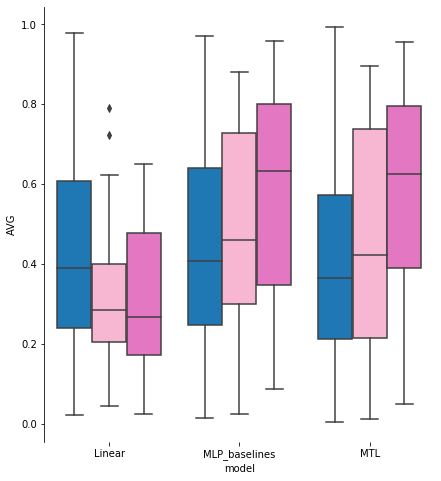

In [374]:
alldfs = pd.concat(dfs.values())
strains_to_plot =  ["WILD","HET_TASTPM", "HO_TASTPM"]
alldfs = alldfs[np.in1d(alldfs["strain"],strains_to_plot)]


f, ax = plt.subplots(1,1,figsize=(7,8))

g=sns.catplot(x="model", y="AVG", hue="strain",aspect=1.2,kind="box", data=alldfs, 
              hue_order=["WILD","HET_TASTPM", "HO_TASTPM"],ax=ax,
              palette=[cmaplist[0], cmaplist[13],  cmaplist[12]],saturation=1);


ax.set_facecolor('None')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.get_legend().remove()
plt.close(2)


## Blood

In [376]:
source_list = ['Blood_GSE63060', 'Blood_GSE63061', "all"]

t_stat = {}
t_ps= {}
dfs = {}
for mod in mods:
    df = pd.read_csv(path_to_preds + "%s/Blood.csv"%mod)
    df["model"] = mod
    dfs[mod] = df

    
    t_stat[mod] = {}
    t_ps[mod] = {}
            
    for source in source_list:
        t_stat[mod][source] = {}
        t_ps[mod][source] = {}
        
        if source=="all":
            subdf = df
        else:
            subdf = df[df["source"]==source]
            
                
        
        for yvar in ['CERAD', 'BRAAK', 'PLAQUES', 'TANGLES',
               'ABETA_IHC', 'TAU_IHC', 'AB_RELATED', 'TAU_RELATED', 'AVG']:

            t_stat[mod][source][yvar] = {}
            t_ps[mod][source][yvar] = {}
                
            for cogstat in ["MCI", "AD"]:
                t,p = scipy.stats.ttest_ind(subdf[subdf["status"]==cogstat][yvar].values, subdf[subdf["status"]=="CTL"][yvar].values)
                t_stat[mod][source][yvar][cogstat] = t
                t_ps[mod][source][yvar][cogstat] = p


Blood_GSE63060 MCI [-0.8271804039826145, 5.826285311498588, 7.141969216045332]
Blood_GSE63060 AD [0.09376092012060908, 4.800248450985506, 5.130663006549931]
Blood_GSE63061 MCI [1.3965259777810883, 4.00516442605161, 3.6636043786162222]
Blood_GSE63061 AD [0.5758522146112754, 4.131223951910157, 3.390285547100494]
all MCI [0.552017003530774, 6.832594570105625, 7.344085594943115]
all AD [0.5541776001766875, 6.231916978428108, 5.8673311499724585]


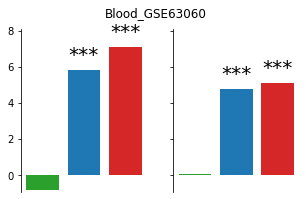

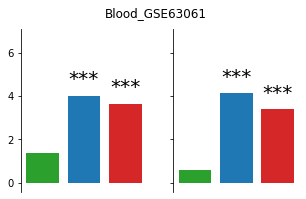

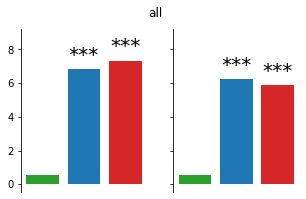

In [377]:
for source in source_list:

    for yvar in ['AVG']:

        f,axs = plt.subplots(1,2, figsize=(5,3), sharey=True)

        low_lim = np.min([[t_stat[mod][source][yvar][cogstat] for mod in ["Linear", "MLP_baselines", "MTL"]] for dset in t_ps["Linear"][source]["CERAD"].keys()])
        high_lim = np.max([[t_stat[mod][source][yvar][cogstat] for mod in ["Linear", "MLP_baselines", "MTL"]] for dset in t_ps["Linear"][source]["CERAD"].keys()])


        for i, cogstat in enumerate(t_ps["Linear"][source]["CERAD"].keys()):
            Ys = [t_stat[mod][source][yvar][cogstat] for mod in ["Linear", "MLP_baselines", "MTL"]]

            lin,mlp,mtl= axs[i].bar(mods, Ys, align='center', alpha=1, ecolor='black')
            
            print(source, cogstat,[t_stat[mod][source][yvar][cogstat] for mod in ["Linear", "MLP_baselines", "MTL"]])



            lin.set_facecolor(cmaplist[4])
            mlp.set_facecolor(cmaplist[0])
            mtl.set_facecolor(cmaplist[6])

            axs[i].set_xticks([])

            annots = [ "***" if x > -np.log10(.001) else ("**" if x > -np.log10(.01) else \
                    ("*" if x > -np.log10(.05) else "")) for x in \
                    [-np.log10(t_ps[mod][source][yvar][cogstat]) for mod in ["Linear", "MLP_baselines", "MTL"]]]
            for j, txt in enumerate(annots):
                ann_x = j
                ann_y = (Ys[j]+.5) if Ys[j]>0 else  (Ys[j]-.5) 
                axs[i].text(ann_x,ann_y, txt, color='black', horizontalalignment ="center", fontsize=20)
            axs[i].set_ylim(low_lim-1,high_lim+3)


            axs[i].spines['right'].set_visible(False)
            axs[i].spines['top'].set_visible(False)
            axs[i].spines['bottom'].set_visible(False)

            axs[i].locator_params(nbins=5, axis='y')
    
        f.suptitle(source)
#         plt.tight_layout()

In [378]:
# TEMP: compare het and ho for bar chart alts
for mod in mods:
    df = dfs[mod]
    for yvar in ['AVG']:
        
        t,p = scipy.stats.ttest_ind(df[df["status"]=="AD"][yvar].values, df[df["status"]=="MCI"][yvar].values)

        print("%s: t=%.3f, p=%.4f"%(mod, t, p))



Linear: t=-0.056, p=0.9556
MLP_baselines: t=-0.902, p=0.3673
MTL: t=-1.794, p=0.0734


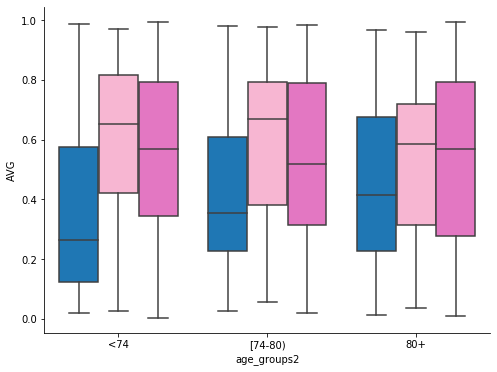

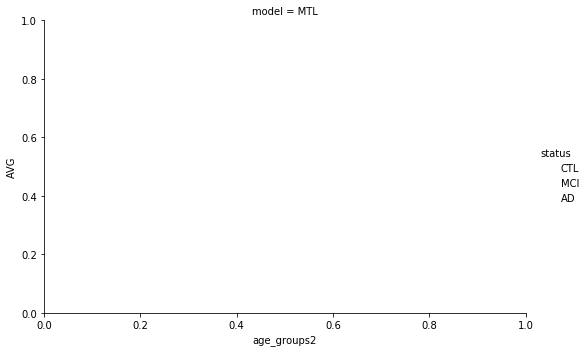

In [379]:
yvar="AVG"    

agevar = "age_groups2"
agelist = ["<74", "[74-80)", "80+"]



f, ax = plt.subplots(1,1,figsize=(8,6))

g=sns.catplot(x=agevar, y=yvar, hue="status",aspect=1.5,kind="box",
        data=dfs["MTL"], order = agelist, hue_order=["CTL","MCI", "AD"], ax=ax,
              palette=[cmaplist[0], cmaplist[13],  cmaplist[12]],saturation=1, col="model")


ax.set_facecolor('None')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

In [380]:

for key in dfs.keys():
    df = dfs[key]
    print(key)

    groups = []
    vals = []
    df["status+age"] = df["status"]+"-"+df[agevar]
    statuses = ["CTL", "MCI", "AD"]
    ages = agelist
    
    for a in ages:
        for s in statuses:
            g = "%s-%s"%(s,a)
            groups.append(g)
            vals.append(df[df["status+age"]==g]["AVG"].values)
    
    
    groups = np.array(groups)
    vals = np.array(vals)

    for i, g_name in enumerate(groups):
        print(g_name+" (%i),"%len(vals[i]), end="")
        for j, g2_name in enumerate(groups):
            t_res = scipy.stats.ttest_ind(vals[i], vals[j])
            stars = ""
            if t_res[1] < .05:
                stars += "*"
            if t_res[1] < .01:
                stars += "*"
            if t_res[1] < .001:
                stars += "*"

            print(stars+",",end="")
        print()
        
    print("\n\n")

Linear
CTL-<74 (113),,*,,,,,,,,
MCI-<74 (64),*,,*,*,**,,*,**,*,
AD-<74 (89),,*,,,,,,,,
CTL-[74-80) (82),,*,,,,,,,,
MCI-[74-80) (63),,**,,,,,,,,
AD-[74-80) (90),,,,,,,,,,
CTL-80+ (43),,*,,,,,,,,
MCI-80+ (62),,**,,,,,,,,
AD-80+ (105),,*,,,,,,,,



MLP_baselines
CTL-<74 (113),,***,***,,***,***,,***,***,
MCI-<74 (64),***,,,***,,,**,,,
AD-<74 (89),***,,,***,,,**,,,
CTL-[74-80) (82),,***,***,,***,*,,**,**,
MCI-[74-80) (63),***,,,***,,,**,,,
AD-[74-80) (90),***,,,*,,,,,,
CTL-80+ (43),,**,**,,**,,,,,
MCI-80+ (62),***,,,**,,,,,,
AD-80+ (105),***,,,**,,,,,,



MTL
CTL-<74 (113),,***,***,,***,***,,***,***,
MCI-<74 (64),***,,,***,,*,**,,,
AD-<74 (89),***,,,***,,,*,,,
CTL-[74-80) (82),,***,***,,***,**,,**,**,
MCI-[74-80) (63),***,,,***,,,**,,,
AD-[74-80) (90),***,*,,**,,,,,,
CTL-80+ (43),,**,*,,**,,,,,
MCI-80+ (62),***,,,**,,,,,,
AD-80+ (105),***,,,**,,,,,,





In [381]:
sourcedata_cols = ["status", "age_groups2"]
sourcedata = dfs["MTL"][sourcedata_cols]


for mod in mods:
    if mod=="MTL":
        sourcedata["MD-AD_predicted_neuropath_score"] = dfs[mod]["AVG"]
    else:
        sourcedata[mod+"_predicted_neuropath_score"] = dfs[mod]["AVG"]
    
sourcedata.rename(columns={"status":"cognitive status", "age_groups2":"age_groups"}, inplace=True)
sourcedata.to_csv("sourcedata/7ab_ext_val_human_blood.csv", index=False)

/homes/gws/nbbwang/anaconda3/envs/py36-test2/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/homes/gws/nbbwang/anaconda3/envs/py36-test2/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/homes/gws/nbbwang/anaconda3/envs/py36-test2/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docum

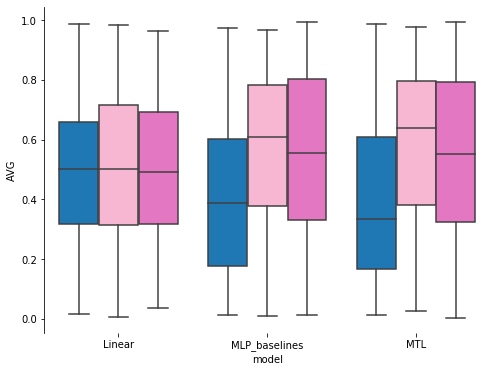

In [382]:
alldfs = pd.concat(dfs.values())


f, ax = plt.subplots(1,1,figsize=(8,6))

g=sns.catplot(x="model", y="AVG", hue="status",aspect=1.2,kind="box", data=alldfs, 
              hue_order=["CTL","MCI", "AD"],ax=ax,
              palette=[cmaplist[0], cmaplist[13],  cmaplist[12]],saturation=1);


ax.set_facecolor('None')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.get_legend().remove()
plt.close(2)
